# Vacuole Volumetry Analysis (WebKnossos .stl export)
This notebook reads .stl files downloaded from WebKnossos and performs data visualization and hyptothesis testing for the presence and distribution of neurodegenerative vacuoles. 

Before you begin, organize the .stl files as follows - 

    ├── inputs/
    │   ├── condition_name/
    │   │   ├── vacuoles/
    │   │   │   ├── mesh-1.stl
    │   │   │   ├── mesh-2.stl
    │   │   └── wholebrain/
    │   │       ├── mesh-1.stl


## Import required packages

In [14]:
from stl import mesh
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt, operator as op
import glob
from pathlib import Path
import seaborn as sns
from collections import defaultdict
import pandas as pd
from scipy import stats 
import numpy as np


## Set up directories and experiment info 

In [27]:
# Set up input and output directories 
base_path = Path("/Users/sbandya/Desktop/neurodegeneration_vacuole_quantification/inputs/vacuole_volumetry_protocolpaper_2024/inputs/")
outputs = Path("/Users/sbandya/Desktop/neurodegeneration_vacuole_quantification/outputs/liu_bandyadka_2024/numpy_stl")

# Create a list of experimental groups being compared (Input folder names must start with items in this list)
conditions = ["repoUASLexARNAi","repoUASdrprRNAi"] 
color_scheme = {"repoUASLexARNAi":"darkorange","repoUASdrprRNAi": "dodgerblue" }
x_label_names = ["repo>LexARNAi","repo>drprRNAi"] 

# Create a list of all mesh files (.stl) to read
meshfiles = dict()
for condition in conditions:
    inputs = glob.glob(str(base_path.joinpath(condition))+"*")
    meshfiles[condition] = inputs

print(meshfiles)

{'repoUASLexARNAi': ['/Users/sbandya/Desktop/neurodegeneration_vacuole_quantification/inputs/vacuole_volumetry_protocolpaper_2024/inputs/repoUASLexARNAi_female40D_Phalloidin_DAPI_1.5_20240110_7', '/Users/sbandya/Desktop/neurodegeneration_vacuole_quantification/inputs/vacuole_volumetry_protocolpaper_2024/inputs/repoUASLexARNAi_female40D_Phalloidin_DAPI_1.5_20240110_1', '/Users/sbandya/Desktop/neurodegeneration_vacuole_quantification/inputs/vacuole_volumetry_protocolpaper_2024/inputs/repoUASLexARNAi_female40D_Phalloidin_DAPI_1.5_20240110_6', '/Users/sbandya/Desktop/neurodegeneration_vacuole_quantification/inputs/vacuole_volumetry_protocolpaper_2024/inputs/repoUASLexARNAi_female40D_Phalloidin_DAPI_1.5_20240110_8', '/Users/sbandya/Desktop/neurodegeneration_vacuole_quantification/inputs/vacuole_volumetry_protocolpaper_2024/inputs/repoUASLexARNAi_female40D_Phalloidin_DAPI_1.5_20240110_3', '/Users/sbandya/Desktop/neurodegeneration_vacuole_quantification/inputs/vacuole_volumetry_protocolpaper_

## Extract mesh features and compute whole brain and vacuole volumes 

In [16]:
%%capture --no-display
vacuole_metrics = defaultdict(dict)

for condition in meshfiles.keys():
    #For each brain, read the whole brain mesh and all the vacuole meshes 
    for brain in meshfiles[condition]: 
        whole_brain = mesh.Mesh.from_file(glob.glob(str(brain)+"/wholebrain/*.stl")[0])
        vacuoles = glob.glob(str(brain)+"/vacuoles/*.stl")
        
        whole_brain_volume =  whole_brain.get_mass_properties()[0]
        
        vacuole_volumes = list()
        for meshfile in vacuoles:
            vacuole = mesh.Mesh.from_file(meshfile)
            volume, cog, inertia = vacuole.get_mass_properties()
            vacuole_volumes.append(volume)
        
        #calculate the %volume occupied by vacuoles in brain 
        percent_vacuole_volume_per_brain = 100*sum(vacuole_volumes)/whole_brain_volume

        #compile all metrics per brain into a dictionary with brainID as key and metrics as values 
        vacuole_metrics[brain.split("/")[-1]] = {"condition": condition,
                                                 "num_vacuoles":len(vacuole_volumes),
                                                 "percent_vacuole_volume": percent_vacuole_volume_per_brain,
                                                 "vacuole_volumes": vacuole_volumes,
                                                 "vacuole_volumes_brain_normalized": vacuole_volumes/whole_brain_volume,
                                                 "whole_brain_volume": whole_brain_volume
                                                }
        
        


## Create a dataframe of vacuole features for downstream analysis

In [17]:
# create a dataframe with all vacuole metrics from all brains of all experimental groups. 
vacuole_metrics_df = pd.DataFrame.from_dict(vacuole_metrics)
vacuole_metrics_df_t = vacuole_metrics_df.transpose()
vacuole_metrics_df_t['sample'] = vacuole_metrics_df_t.index
vacuole_metrics_df_t[:5]

,condition,num_vacuoles,percent_vacuole_volume,vacuole_volumes,vacuole_volumes_brain_normalized,whole_brain_volume,sample
repoUASLexARNAi_female40D_Phalloidin_DAPI_1.5_20240110_7,repoUASLexARNAi,0,0.0,[],[],8819930977031509.0,repoUASLexARNAi_female40D_Phalloidin_DAPI_1.5_...
repoUASLexARNAi_female40D_Phalloidin_DAPI_1.5_20240110_1,repoUASLexARNAi,2,0.172803,"[2795949905237.3335, 13926064237226.666]","[0.0002889293401672817, 0.0014390989422421478]",9676933133957802.0,repoUASLexARNAi_female40D_Phalloidin_DAPI_1.5_...
repoUASLexARNAi_female40D_Phalloidin_DAPI_1.5_20240110_6,repoUASLexARNAi,7,0.106136,"[2048437278037.3333, 2311718655317.3335, 93026...","[0.00020814938869295825, 0.0002349023961306960...",9841188056809472.0,repoUASLexARNAi_female40D_Phalloidin_DAPI_1.5_...
repoUASLexARNAi_female40D_Phalloidin_DAPI_1.5_20240110_8,repoUASLexARNAi,3,0.031799,"[378919343445.3333, 1542522120874.6667, 128904...","[3.7531423469150917e-05, 0.0001527846279967814...",10096055742644224.0,repoUASLexARNAi_female40D_Phalloidin_DAPI_1.5_...
repoUASLexARNAi_female40D_Phalloidin_DAPI_1.5_20240110_3,repoUASLexARNAi,3,0.043684,"[361883828224.0, 743900763477.3334, 2903370257...","[3.943105656195962e-05, 8.105582729439673e-05,...",9177634579873792.0,repoUASLexARNAi_female40D_Phalloidin_DAPI_1.5_...


## Data Exploration and Visualization 
### Distribution of number of vacuoles per brain 

/var/folders/8k/y9p1gcl95112m767j4mf_jhh0000gn/T/ipykernel_61058/2806664542.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y= vacuole_metrics_df_t["num_vacuoles"].astype(float),
/var/folders/8k/y9p1gcl95112m767j4mf_jhh0000gn/T/ipykernel_61058/2806664542.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_label_names, rotation=45,
/var/folders/8k/y9p1gcl95112m767j4mf_jhh0000gn/T/ipykernel_61058/2806664542.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontdict={'weight': 'bold'})


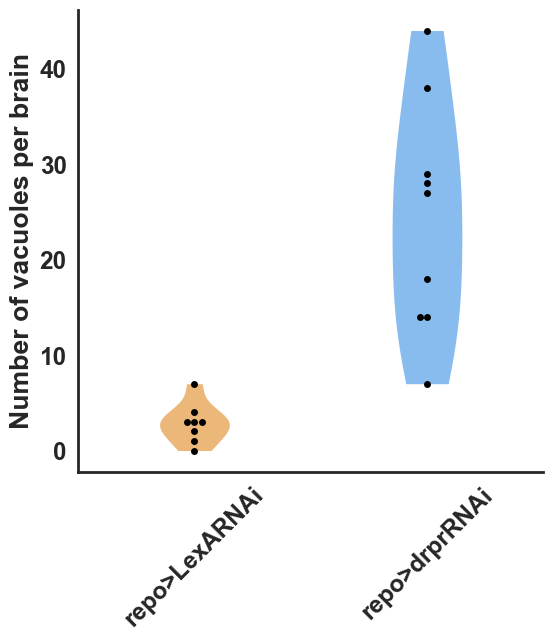

In [28]:

sns.set_style('white')
sns.set_context("paper", font_scale = 2)

fig, ax = plt.subplots( figsize=(6, 6))

sns.violinplot(y= vacuole_metrics_df_t["num_vacuoles"].astype(float),
              x = vacuole_metrics_df_t["condition"], 
              ax=ax, palette=color_scheme, inner=None, linewidth=0,
              width=0.3,cut=0, alpha=0.6)
sns.swarmplot(y= vacuole_metrics_df_t["num_vacuoles"].astype(float),
              x = vacuole_metrics_df_t["condition"], ax=ax, color="black")

sns.despine(right = True)
ax.set_xticklabels(x_label_names, rotation=45,                       
                  fontdict={'weight': 'bold'})
ax.set_yticklabels(ax.get_yticklabels(),fontdict={'weight': 'bold'})
ax.set_ylabel("Number of vacuoles per brain",fontdict={'weight': 'bold'})
ax.set_xlabel("")
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
fig.savefig(outputs.joinpath("num_vacuoles_violin.pdf"), bbox_inches='tight') 

/var/folders/8k/y9p1gcl95112m767j4mf_jhh0000gn/T/ipykernel_61058/117000420.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y= vacuole_metrics_df_t["num_vacuoles"].astype(float),
/var/folders/8k/y9p1gcl95112m767j4mf_jhh0000gn/T/ipykernel_61058/117000420.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_label_names, rotation=45,
/var/folders/8k/y9p1gcl95112m767j4mf_jhh0000gn/T/ipykernel_61058/117000420.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontdict={'weight': 'bold'})


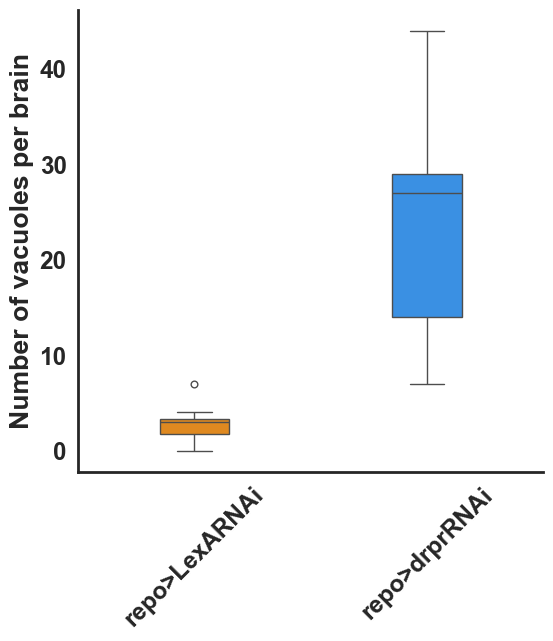

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(y= vacuole_metrics_df_t["num_vacuoles"].astype(float),
               x= vacuole_metrics_df_t["condition"],  
               palette = color_scheme, linewidth = 1,  ax = ax, width=0.3
          )

sns.despine(right = True)
ax.set_xticklabels(x_label_names, rotation=45,
                  fontdict={'weight': 'bold'})
ax.set_yticklabels(ax.get_yticklabels(),fontdict={'weight': 'bold'})
ax.set_ylabel("Number of vacuoles per brain",fontdict={'weight': 'bold'})
ax.set_xlabel("")
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
fig.savefig(outputs.joinpath("num_vacuoles_box.pdf"), bbox_inches='tight') 

### Percent of whole brain volume occupied by vacuoles 

/var/folders/8k/y9p1gcl95112m767j4mf_jhh0000gn/T/ipykernel_61058/3107988364.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y= vacuole_metrics_df_t["percent_vacuole_volume"].astype(float),
/var/folders/8k/y9p1gcl95112m767j4mf_jhh0000gn/T/ipykernel_61058/3107988364.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_label_names, rotation=45,
/var/folders/8k/y9p1gcl95112m767j4mf_jhh0000gn/T/ipykernel_61058/3107988364.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontdict={'weight': 'bold'})


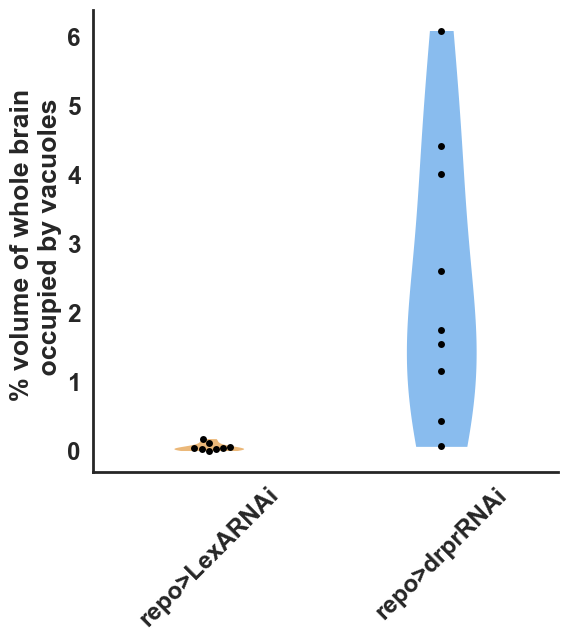

In [30]:
fig, ax = plt.subplots(figsize=(6,6))
sns.violinplot(y= vacuole_metrics_df_t["percent_vacuole_volume"].astype(float),
              x = vacuole_metrics_df_t["condition"], 
              ax=ax, palette=color_scheme, inner=None, linewidth=0,
              width=0.3,cut=0, alpha=0.6)
sns.swarmplot(y= vacuole_metrics_df_t["percent_vacuole_volume"].astype(float),
              x = vacuole_metrics_df_t["condition"], ax=ax, color="black")

sns.despine(right = True)
ax.set_xticklabels(x_label_names, rotation=45,
                  fontdict={'weight': 'bold'})
ax.set_yticklabels(ax.get_yticklabels(),fontdict={'weight': 'bold'})
ax.set_ylabel("% volume of whole brain \n occupied by vacuoles",fontdict={'weight': 'bold'})
ax.set_xlabel("")
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
fig.savefig(outputs.joinpath("percent_vacuoles_violin.pdf"), bbox_inches='tight') 

/var/folders/8k/y9p1gcl95112m767j4mf_jhh0000gn/T/ipykernel_61058/3512901280.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y= vacuole_metrics_df_t["percent_vacuole_volume"].astype(float),
/var/folders/8k/y9p1gcl95112m767j4mf_jhh0000gn/T/ipykernel_61058/3512901280.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_label_names, rotation=45,
/var/folders/8k/y9p1gcl95112m767j4mf_jhh0000gn/T/ipykernel_61058/3512901280.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontdict={'weight': 'bold'})


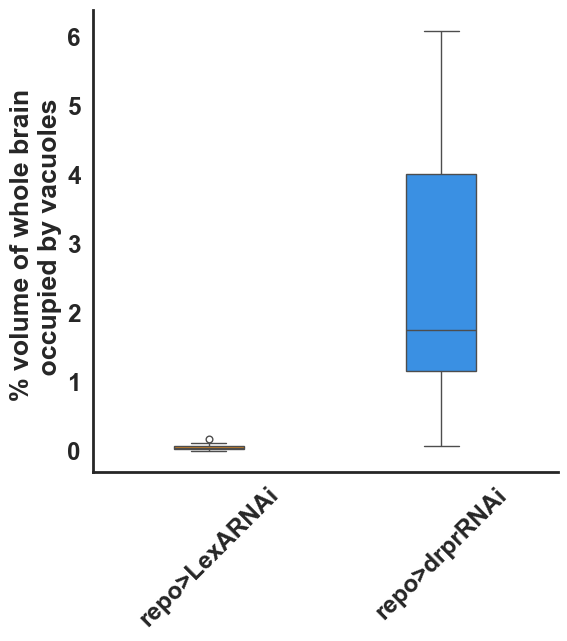

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(y= vacuole_metrics_df_t["percent_vacuole_volume"].astype(float),
               x= vacuole_metrics_df_t["condition"], linewidth = 1,
               palette = color_scheme, ax = ax, width=0.3
          )

sns.despine(right = True)
ax.set_xticklabels(x_label_names, rotation=45,
                  fontdict={'weight': 'bold'})
ax.set_yticklabels(ax.get_yticklabels(),fontdict={'weight': 'bold'})
ax.set_ylabel("% volume of whole brain \n occupied by vacuoles",fontdict={'weight': 'bold'})
ax.set_xlabel("")
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
fig.savefig(outputs.joinpath("percent_vacuoles_box.pdf"), bbox_inches='tight') 



### Distribution of vacuole volumes 

/Users/sbandya/miniconda3/envs/hemocyte_analysis/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 72.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/8k/y9p1gcl95112m767j4mf_jhh0000gn/T/ipykernel_61058/664667146.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_label_names, rotation=45,
/var/folders/8k/y9p1gcl95112m767j4mf_jhh0000gn/T/ipykernel_61058/664667146.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontdict={'weight': 'bold'})
/Users/sbandya/miniconda3/envs/hemocyte_analysis/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 77.2% of the points cannot be placed; you may want to decrease the size of the ma

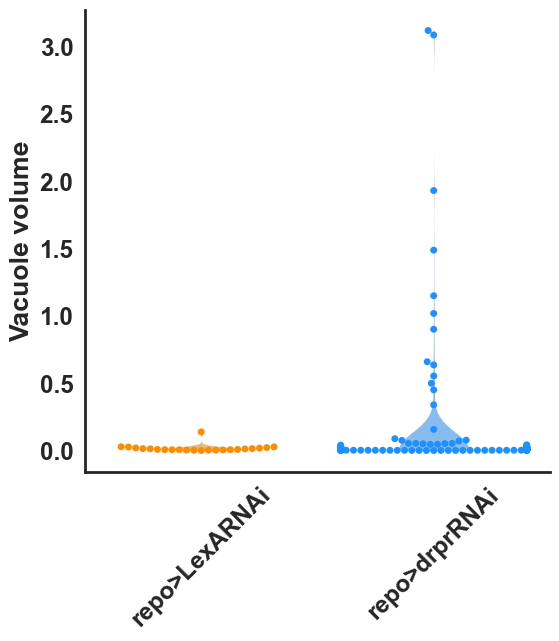

In [32]:

repo_drpr_vacuole_volumes = list()
repo_lexA_vacuole_volumes = list()
for i, row in vacuole_metrics_df_t.iterrows():
    if row["condition"] == "repoUASdrprRNAi":
       repo_drpr_vacuole_volumes.append([i for i in row["vacuole_volumes"]])
    else:
        repo_lexA_vacuole_volumes.append([i for i in row["vacuole_volumes"]])
repo_drpr_vacuole_volumes_flat = [i for ic in repo_drpr_vacuole_volumes for i in ic]
repo_lexA_vacuole_volumes_flat = [i for ic in repo_lexA_vacuole_volumes for i in ic] 


fig, ax = plt.subplots(figsize=(6,6))
sns.violinplot({"repoUASLexARNAi" :repo_lexA_vacuole_volumes_flat,
               "repoUASdrprRNAi" :repo_drpr_vacuole_volumes_flat}, 
                palette = color_scheme,  ax = ax, 
                inner=None, linewidth=0,
                width=0.3,cut=0, alpha=0.6)
sns.swarmplot({"repoUASLexARNAi" :repo_lexA_vacuole_volumes_flat,
               "repoUASdrprRNAi" :repo_drpr_vacuole_volumes_flat}, 
                palette = color_scheme,  ax = ax
               )

sns.despine(right = True)
ax.set_xticklabels(x_label_names, rotation=45,
                  fontdict={'weight': 'bold'})
ax.set_yticklabels(ax.get_yticklabels(),fontdict={'weight': 'bold'})
ax.set_ylabel("Vacuole volume",fontdict={'weight': 'bold'})
ax.set_xlabel("")
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

fig.savefig(outputs.joinpath("vacuole_volume_distribution.pdf"), bbox_inches='tight') 

### Distribution of vacuole volumes normalized by whole brain volume

/Users/sbandya/miniconda3/envs/hemocyte_analysis/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 74.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/8k/y9p1gcl95112m767j4mf_jhh0000gn/T/ipykernel_61058/2084567103.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_label_names, rotation=45,
/var/folders/8k/y9p1gcl95112m767j4mf_jhh0000gn/T/ipykernel_61058/2084567103.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontdict={'weight': 'bold'})
/Users/sbandya/miniconda3/envs/hemocyte_analysis/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 79.0% of the points cannot be placed; you may want to decrease the size of the 

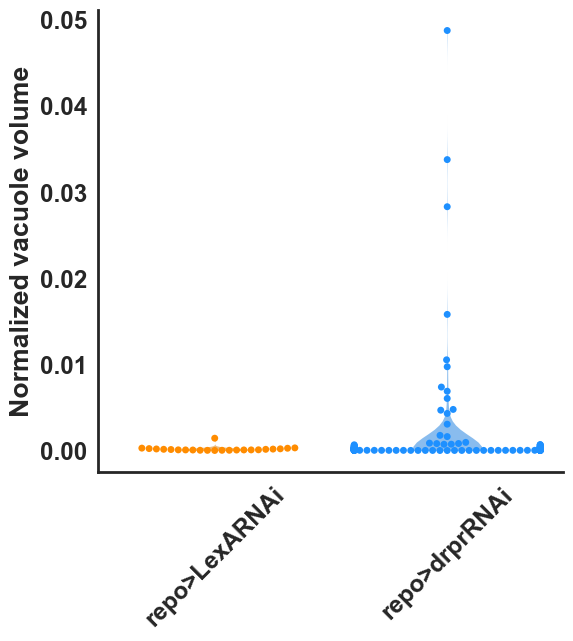

In [33]:

repo_drpr_vacuole_volumes_normalized = list()
repo_lexA_vacuole_volumes_normalized = list()
for i, row in vacuole_metrics_df_t.iterrows():
    if row["condition"] == "repoUASdrprRNAi":
       repo_drpr_vacuole_volumes_normalized.append([i for i in row["vacuole_volumes_brain_normalized"]])
    else:
        repo_lexA_vacuole_volumes_normalized.append([i for i in row["vacuole_volumes_brain_normalized"]])
repo_drpr_vacuole_volumes_flat_normalized = [i for ic in repo_drpr_vacuole_volumes_normalized for i in ic]
repo_lexA_vacuole_volumes_flat_normalized = [i for ic in repo_lexA_vacuole_volumes_normalized for i in ic] 


fig, ax = plt.subplots(figsize=(6,6))
sns.violinplot({"repoUASLexARNAi" :repo_lexA_vacuole_volumes_flat_normalized,
               "repoUASdrprRNAi" :repo_drpr_vacuole_volumes_flat_normalized}, 
                palette = color_scheme,  ax = ax, 
                inner=None, linewidth=0,
                width=0.3,cut=0, alpha=0.6)
sns.swarmplot({"repoUASLexARNAi" :repo_lexA_vacuole_volumes_flat_normalized,
               "repoUASdrprRNAi" :repo_drpr_vacuole_volumes_flat_normalized}, 
                palette = color_scheme,  ax = ax
               )
sns.despine(right = True)
ax.set_xticklabels(x_label_names, rotation=45,
                  fontdict={'weight': 'bold'})
ax.set_yticklabels(ax.get_yticklabels(),fontdict={'weight': 'bold'})
ax.set_ylabel("Normalized vacuole volume",fontdict={'weight': 'bold'})
ax.set_xlabel("")
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
fig.savefig(outputs.joinpath("vacuole_volume_distribution_normalized.pdf"), bbox_inches='tight') 

## Hypothesis testing
### Number of vacuoles between experimental conditions (Independent 2-sample t-test )

In [24]:
vacuole_metrics_df_t_conditionindex = vacuole_metrics_df_t[["condition","num_vacuoles"]].set_index("condition")
repo_drpr = vacuole_metrics_df_t_conditionindex["num_vacuoles"].loc["repoUASdrprRNAi"].to_list()
repo_lexA = vacuole_metrics_df_t_conditionindex["num_vacuoles"].loc["repoUASLexARNAi"].to_list()

print("median number of vacuoles in repo>drprRNAi: ",np.median(repo_drpr))
print("median number of vacuoles in repo>LexARNAi: ",np.median(repo_lexA))
print("mean number of vacuoles in repo>drprRNAi: ",np.mean(repo_drpr))
print("mean number of vacuoles in repo>LexARNAi: ",np.mean(repo_lexA))
print("difference in means :",np.mean(repo_drpr)-np.mean(repo_lexA))
stats.ttest_ind(repo_drpr,repo_lexA,alternative="greater")


median number of vacuoles in repo>drprRNAi:  27.0
median number of vacuoles in repo>LexARNAi:  3.0
mean number of vacuoles in repo>drprRNAi:  24.333333333333332
mean number of vacuoles in repo>LexARNAi:  2.875
difference in means : 21.458333333333332


TtestResult(statistic=4.935538028697458, pvalue=8.974217949973156e-05, df=15.0)

### Percent whole brain volume occupied by vacuoles (Independent 2-sample t-test )

In [36]:
vacuole_metrics_df_t_conditionindex_percentvacuole = vacuole_metrics_df_t[["condition","percent_vacuole_volume"]].set_index("condition")
repo_drpr = vacuole_metrics_df_t_conditionindex_percentvacuole["percent_vacuole_volume"].loc["repoUASdrprRNAi"].to_list()
repo_lexA = vacuole_metrics_df_t_conditionindex_percentvacuole["percent_vacuole_volume"].loc["repoUASLexARNAi"].to_list()
print("mean %vacuole volume in repo>drprRNAi: ",np.mean(repo_drpr))
print("mean %vacuole volume in repo>LexARNAi: ",np.mean(repo_lexA))
print("difference in means :",np.mean(repo_drpr)-np.mean(repo_lexA))
stats.ttest_ind(repo_drpr,repo_lexA)

stats.ttest_ind(repo_drpr,repo_lexA,alternative="greater")



mean %vacuole volume in repo>drprRNAi:  2.4519540055204705
mean %vacuole volume in repo>LexARNAi:  0.053593887133034854
difference in means : 2.3983601183874357


TtestResult(statistic=3.360537410837306, pvalue=0.00214578090157498, df=15.0)

## Export features as csv file

In [26]:

vacuole_metrics_df_t.to_csv(outputs.joinpath("mesh_vacuole_features.csv"),sep=",")